# Clustering with Scikit-Learn

## Outline

- [1. Load Dataset](#1)
- [2. Hierarchical Clustering](#3)
- [3. DBScan](#4)
- [4. Chameleon clusters data](#5)


First, run the following cell to import some useful libraries to complete this Lab. If not already done, you must install them in your virtual environment

In [22]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

plt.style.use("seaborn-v0_8-dark")

If the previous cell outputs one the following error: `ModuleNotFoundError: No module named 'sklearn'`, then, you have to install the Scikit-Learn package. If you don't remember how to install a Python package, please retrieve the guide on Anaconda-Navigator.

To install **sklearn** you can use one of the following commands from the terminal of your virtual environment: <br>
`pip install -U scikit-learn` <br>
`conda install -c intel scikit-learn`

<a id='1'></a>
## 1. Load dataset

### Exercise 1
Firstly, you will load the first dataset for this lab. Read the csv file from the following path `"data_lab9/lab9_data.csv"` into a DataFrame `df`. The separator of the csv file is the comma `,`. You should skip the header of the first row (i.e., skip the first row) and set the column names to the list stored in the variable `columns`.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>To read a csv file into a DataFrame, you can use pd.read_csv().</li>
    <li>To specify the <strong>separator</strong>, you can set the 'set' parameter.</li>
    <li>To specify the <strong>column names</strong>, you can set the 'names' parameter.</li>
    <li>To specify the <strong>number of rows to skip</strong>, you can set the 'skiprows' parameter.</li>
</ul>
</p>

In [23]:
columns = ['x', 'y', 'gt']

#### START CODE HERE ####
#### Approximately 1 line ####
df = pd.read_csv("data_lab9/lab9_data.csv", sep=",", names=columns, skiprows=1)
#### END CODE HERE ####

print(df)

              x           y  gt
0    516.012706  393.014514   0
1    436.211762  408.656585   0
2    512.052601  372.022014   0
3    489.140464  401.807159   0
4    446.207986  338.516682   0
..          ...         ...  ..
331  638.916471  323.569096   1
332  542.005901  347.527070   0
333  611.964612  377.254978   0
334  520.654168  455.996453   0
335  594.479314  392.901455   0

[336 rows x 3 columns]


#### Expected output
```                x	         y     gt```<br>
```0	516.012706	393.014514	0```<br>
```1	436.211762	408.656585	0```<br>
```2	512.052601	372.022014	0```<br>
```3	489.140464	401.807159	0```<br>
```4	446.207986	338.516682	0```<br>
```...	       ...	       ...    ...```<br>
```331	638.916471	323.569096	1```<br>
```332	542.005901	347.527070	0```<br>
```333	611.964612	377.254978	0```<br>
```334	520.654168	455.996453	0```<br>
```335	594.479314	392.901455	0```<br>
```336 rows × 3 columns```

The dataset is composed of the `x` and `y` coordinates for 336 points, and the True label in the column `gt`.
The next cell will create a DataFrame with the **input features** (i.e., all the `x` and `y` coordinates of the points) into a new DataFrame `df_X`, and a Series containing the **ground-truth labels** `gt_series`. Run the next cell to create the DataFrame and the Series. Notice that, in this case, we also have the **true labels**. Normally, when using clustering, the true labels are **not** available.

In [24]:
df_X = df[["x","y"]].copy()
gt_series = df["gt"].copy()

The next cell defines a function that takes a DataFrames in input, and plots the scatter plot (i.e., the points) contained in the `x` and `y` columns. Run the next cell to define the function.

In [25]:
def plot_2d_scatter(df, title=""):
    """Display a 2D scatter plot
    :param df: input data points, DataFrame ('x' and 'y' coordinates in the first and second column, respectively)
    :return: fig, ax, objects
    """
    fig, ax = plt.subplots(figsize=(6, 5), dpi=90)
    ax.scatter(df.iloc[:,0], df.iloc[:,1])
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("y", fontsize=14)
    ax.set_title(title)
    ax.grid(True)
    return fig, ax # use them for further modifications

The next cell calls the previously defined function and **plots all the points in the input dataset in the plane**. All points are plotted with the same color because you still have not applied clustering. Run the next cell to plot all the points in the plane.

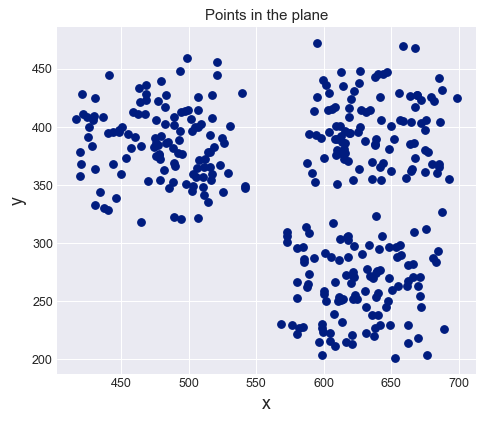

In [26]:
_, _ = plot_2d_scatter(df_X, "Points in the plane")

Notice that, with 2-dimensional data (like in this case), you can easily visualize the number of clusters because you can plot the points in a plane. In this case, it is reasonable to think that there are 3 distinct clusters. However, the procedure that we will apply in this notebook can also be applied with **higher dimensional data**, which is not visualizable in a plane. Therefore, for high dimensional data, it is challenging to visualize the correct number of clusters. You have to select the best number of clusters based on the analysis of the data.

The next cell defines a function that visualizes each cluster in a plane with a different color. It takes as parameters the points stored in a DataFrame `df` with the $x$ and $y$ coordinates of points stored in the `x` and `y` columns, respectively, the list with the predicted cluster id for each point `y_pred`, and an optional plot title `title`. Run the next cell to define the function.

In [27]:
def plot_2d_scatter_with_clusters(df, y_pred, title=""):
    """Display a 2D scatter plot with each cluster with a different color
    :param df: input data points, DataFrame ('x' and 'y' coordinates in the 'x' and 'y' columns, respectively)
    :param y_pred: numpy array with the predicted label for each pointù
    :param title: string containing the title of the chart
    :return: fig, ax, objects
    """
    fig, ax = plt.subplots(figsize=(6, 5), dpi=90)
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("y", fontsize=14)

    n_clusters = list(set(y_pred))
    labels = [f"Cluster {c}" for c in n_clusters]

    for i, label in enumerate(n_clusters):

        if label == -1:
            label_name = "Outliers"
        else:
            label_name = labels[i]

        #add data points
        ax.scatter(x=df.loc[y_pred==label, 'x'],
                    y=df.loc[y_pred==label,'y'],
                    alpha=0.7, label=label_name)

    ax.legend(loc=(1.1, 0.5))
    ax.set_title(title)
    ax.grid(True)

    return fig, ax # use them for further modifications

Firstly, we will plot the points with a different color based on the **ground-truth labels** present in the dataset. As discussed before, this dataset contains the true labels. However, the true labels are usually **not** available when performing clustering. We can see that there are **3 well-separated different clusters**. However, some **noise** is present in the clusters (i.e., some green points are closer to the blue cluster than to the green one, etc.).

Run the next cell to plot the points based on the ground-truth.

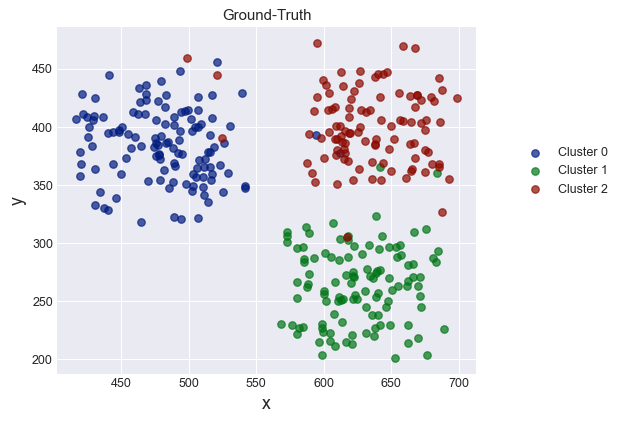

In [28]:
_, _ = plot_2d_scatter_with_clusters(df_X, gt_series, "Ground-Truth")

<a id='3'></a>
## 2. Hierarchical Clustering

Here, is already provided to you the code to run the **Hierarchical clustering**. Run the next cells to perform the hierarchical clustering. The dendrogram of the hierarchical clustering is automatically cut to match the `n_clusters` specified. You can read the documentation of the agglomerative clustering <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html" >here</a>.

In [29]:
n_clusters = 3
hc = AgglomerativeClustering(n_clusters)
y_pred_hc = hc.fit_predict(df_X)

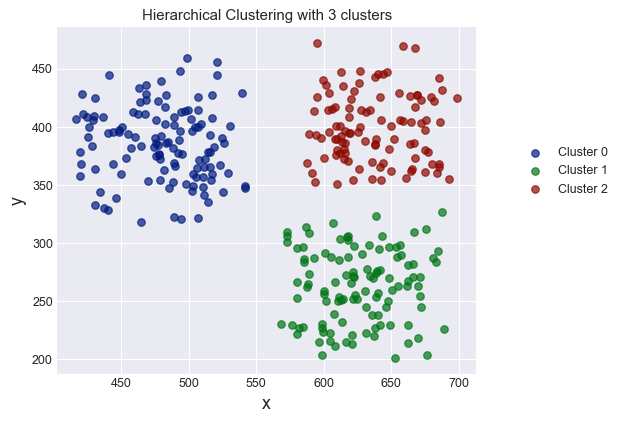

In [30]:
_, _ = plot_2d_scatter_with_clusters(df_X, y_pred_hc, f"Hierarchical Clustering with {n_clusters} clusters")

In [33]:
silh_avg_hc = silhouette_score(df_X, y_pred_hc)
print(silh_avg_hc)

0.6110715619378336


You can see that the result is practically the same.

<a id='4'></a>
## 3. DBScan

Here, is already provided to you the code to run the **Density-based clustering (dbscan)**. Run the next cells to perform the dbscan clustering. The dbscan does not require the specification of the number of clusters. Moreover, it also identifies the outliers. However, it require the specification of two parameters: epsilon and the minimum number of points that are often difficult to set. You can read the documentation of the dbscan clustering <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html" >here</a>.

In [34]:
dbscan = DBSCAN(eps=20, min_samples=10)

In [36]:
y_pred_dbscan= dbscan.fit_predict(df_X)

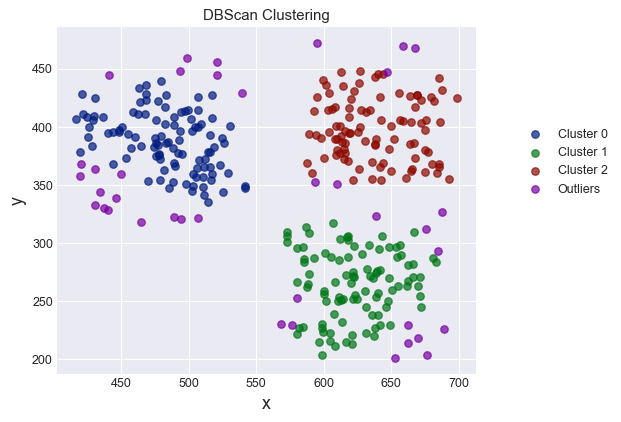

In [37]:
_, _ = plot_2d_scatter_with_clusters(df_X, y_pred_dbscan, "DBScan Clustering")

The red points are the outliers.

<a id='5'></a>
## 4. Chameleon clusters data

Now, you will move to another dataset, the `chameleon_clusters` data. This time the true labels are not available.
The next cell loads the data into a DataFrame `df_X_cc`. Please run the next cell to load the data.

In [38]:
df_X_cc = pd.read_csv("data_lab9/chameleon_clusters.csv", sep=",")
df_X_cc

,x,y
0,68.601997,102.491997
1,454.665985,264.808990
2,101.283997,169.285995
3,372.614990,263.140991
4,300.989014,46.555000
...,...,...
7995,442.420990,303.721985
7996,495.451996,288.502991
7997,267.605011,141.725006
7998,238.358002,252.729996


Run the next cell to plot the points in the plane.

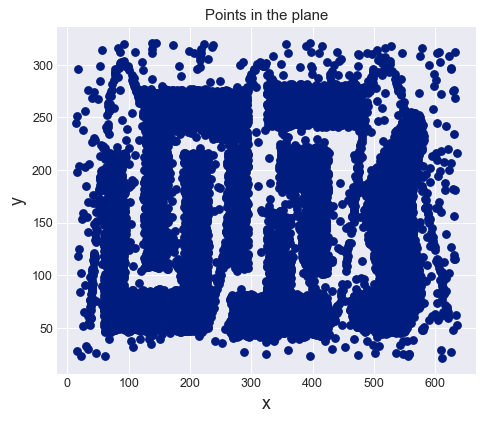

In [39]:
_, _ = plot_2d_scatter(df_X_cc, "Points in the plane")

You can see that this time the points are distributed in a more complicated manner. It is also more difficult to identify the best number of clusters. In addition, there are many points that are outliers.

### Exercise 2

For this type of data with different densities, **dbscan** may be a better choice. Perform the clustering with the **dbscan** algorithm for the data stored in `df_X_cc`. Store the predicted labels in a variable `y_pred_dbscan`. Set the parameters of the DBSCAN object as follows: `eps`=10 and `min_samples`=20. Go ahead and try changing the values to see how the results change. You can read the documentation of the dbscan clustering <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html" >here</a>.

In [54]:
#### START CODE HERE ####
#### Approximately 2 line ####
dbscan_cc = DBSCAN(eps=10, min_samples=20)
y_pred_dbscan = dbscan_cc.fit_predict(df_X_cc)

#### END CODE HERE ####

Now, run the next cell to plot the results.

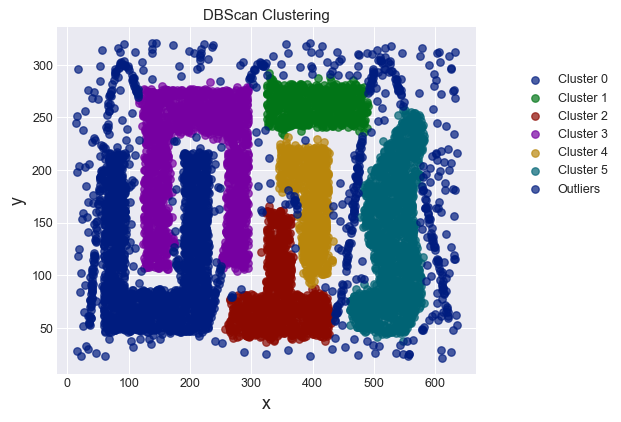

In [55]:
_, _ = plot_2d_scatter_with_clusters(df_X_cc, y_pred_dbscan, "DBScan Clustering")

Graphically, you can see that the DBScan seems to perform much better in this case. It can identify clusters of points and also outliers.